# Predicting DL model outputs for large images by cutting to smaller chunks 

In [1]:
# importing libraries 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

from PIL import Image
from io import BytesIO

## Image cutting
Cut image to the same size chunks

In [2]:
def find_ranges(image, w_x, w_y, d):
    """ gets the CV2 image and cuts it to smaller parts
        image  - CV2 image
        w_x      - squared window length and width, 
        w_y      - squared window length and width, 
        d      - size of the border 
        
        returns - lists of ranges for x and y axis
    """
    
    x_ranges = [[0, d+w_x]]
    for i in range(image.shape[0]//w_x):
        # makes range for x with width max_size and borders buff -  if image is in the edge adds 2*buff to the other side to have fixed size images
        x_s = x_ranges[-1][0] + w_x
        x_e = x_ranges[-1][0] + 2* w_x + d 

#         print(x_s, x_e)
        if x_e <= image.shape[0]:
            x_ranges.append( [x_s, x_e])
        elif x_ranges[-1] != [image.shape[0] - w_x - d, image.shape[0]]:
            x_ranges.append( [image.shape[0] - w_x - d, image.shape[0]])
            
            
    y_ranges = [[0, d+w_y]]
    for i in range(image.shape[1]//w_y):
        # makes range for x with width max_size and borders buff -  if image is in the edge adds 2*buff to the other side to have fixed size images
        y_s = y_ranges[-1][0] + w_y
        y_e = y_ranges[-1][0] + 2* w_y + d 

#         print(y_s, y_e)
        if y_e <= image.shape[1]:
            y_ranges.append( [y_s, y_e])
        elif y_ranges[-1] != [image.shape[1] - w_y - d, image.shape[1]]:
            y_ranges.append( [image.shape[1] - w_y - d, image.shape[1]])

    
    return x_ranges, y_ranges



def cut_image(img, w_x, w_y, buff):
    """
    gets the CV2 image and cuts it to smaller parts. uses find_ranges() function.
    img      - CV2 image
    w_x      - squared window length and width, 
    w_y      - squared window length and width, 
    buff     - size of the border 
    
    returns  - dictionary of chunked parts of an image, touple of indexes
    """
    
    x_ranges, y_ranges = find_ranges(img, w_x, w_y, buff)
    
    chunks = dict()

    for i, (x_s , x_e) in  enumerate(x_ranges):
        for j, (y_s , y_e) in enumerate(y_ranges):
#             print(x_s,x_e, y_s , y_e)
            chunks['{}_{}'.format(i,j)] = img[x_s : x_e, y_s : y_e]
            
    return chunks, (x_ranges, y_ranges)
    

## Open image from URL 
Open image from URL and convert it to cv2 format


Image shape is (866, 1300, 3)


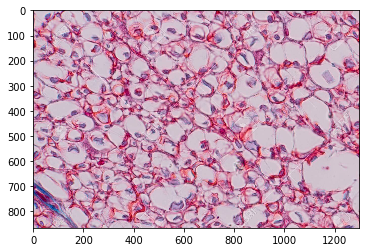

In [3]:
# open image from url
response = requests.get('https://previews.123rf.com/images/sinhyu/sinhyu1909/sinhyu190900083/130037985-nerve-human-under-the-microscope-for-education-in-lab-.jpg')
image = Image.open(BytesIO(response.content))

# convert to cv2 
img_arr = np.array(image)

print("Image shape is {}".format(img_arr.shape))
plt.imshow(img_arr)

In [4]:
# define core window size and buffer size 
x_size = 400
y_size = 280
buff = 100

# cut image to smaller pieces 
chunks , (x_ranges, y_ranges) = cut_image(img_arr, x_size, y_size, buff )
print("X ranges : {}\nY ranges : {}".format(x_ranges, y_ranges))

X ranges : [[0, 500], [366, 866]]
Y ranges : [[0, 380], [280, 660], [560, 940], [840, 1220], [920, 1300]]


## Visualisation of image cutting

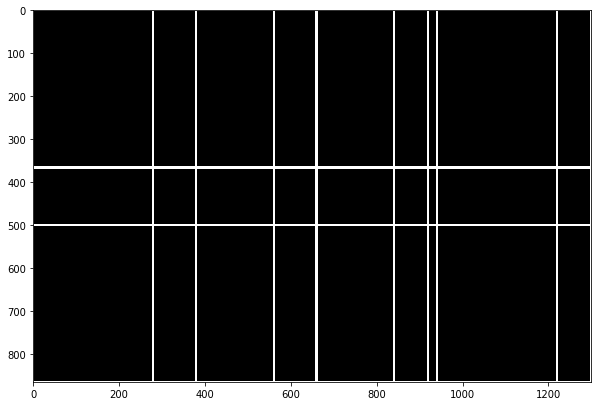

In [5]:
#create black background
black  = np.zeros_like(image)

fig = plt.figure(figsize =(10,10))

for i,  (x_s , x_e) in  enumerate(x_ranges):    
    for j, (y_s , y_e) in enumerate(y_ranges):
        cv2.rectangle(black, (y_s,x_s), (y_e, x_e), color =[255,255,255], thickness =3)

plt.imshow(black)

# Model
For simplicity of demonstration, we use CV2 Canny edge detection as our model

In [6]:
def predict(img):
    """
    Gets any cv2 image and returns a grayscale image of edges. 
    """
    return cv2.Canny(img,100,200)


## Assembling Image with borders removed
Assemble image from cuts:

    Adding images to a black background. 
    Images will overlap if the buffer is nor removed completely
    Calculating overlap regions and dividing to number of overlapped images, that gives a smooth transition from chunk to chunk 

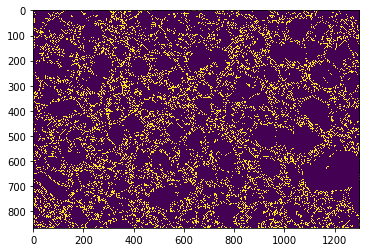

In [7]:
# predict on the whole image to compare to the reconstructed image 

pred_large = predict(img_arr)
plt.imshow(pred_large)

In [8]:
img_rec = np.zeros_like(pred_large, dtype=np.float32)
counts  = np.zeros_like(pred_large)

# defile how many pixels to remove from borders to avoid incorrectly detected regions closer to the borders
bord = buff//5

# for each chunk of the image run detection model and combine in one large picture
for i, (x_s , x_e) in  enumerate(x_ranges):
    for j, (y_s , y_e) in enumerate(y_ranges):
        # predict on chunk
        temp_img = predict(chunks['{}_{}'.format(i,j)])

        #calculate overlapings
        counts[x_s + bord: x_e - bord, y_s + bord : y_e - bord ] += 1
        #pasting image with border removed
        img_rec[x_s + bord: x_e - bord, y_s + bord : y_e - bord ] += temp_img[bord: - bord, bord: - bord]

# replacing zeros with ones near the border of a large image, to avoid division by zero
counts[counts==0] = 1
# dividing image pixel values to counts
img_rec /= counts

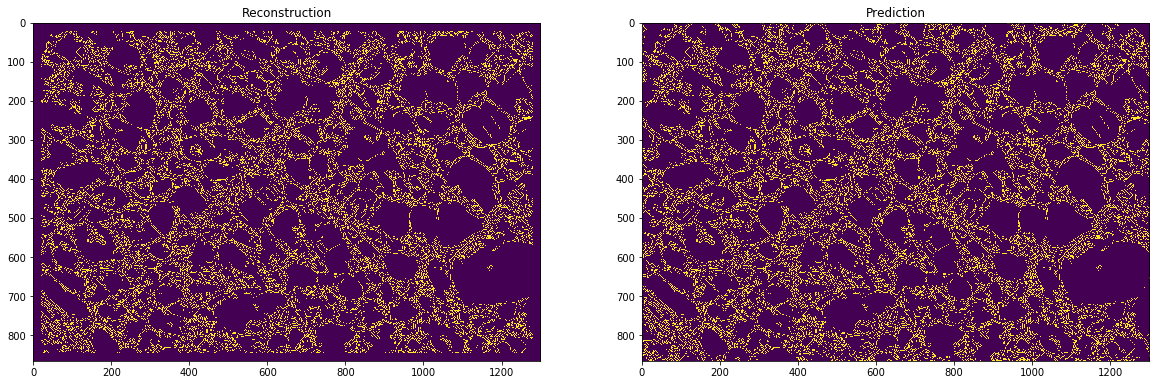

In [9]:
# visualisaton of Reconstruction and original Prediction

fig = plt.figure(figsize = (20, 7))
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img_rec)
a.set_title('Reconstruction')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(pred_large)
a.set_title('Prediction')

plt.show()

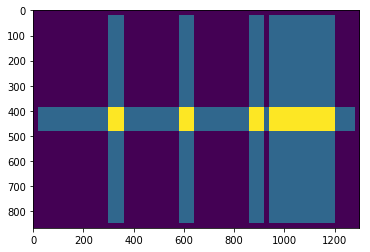

In [10]:
# visualize regions where 1, 2, or 3 chunks of images overlap
plt.imshow(counts)